## Data

In [43]:
import os
import requests
import time
import zipfile
import shutil
from tqdm import tqdm
import json

import sqlite3
import pandas as pd



In [14]:
KAGGLE_JSON_PATH = "kaggle.json" 
from kaggle.api.kaggle_api_extended import KaggleApi


In [44]:
DATA_DIR = "data"
FULL_DATA_DIR = os.path.join(DATA_DIR, "full-data")


In [12]:
import warnings
warnings.filterwarnings("ignore")

### Downloading and cleaning initial data files

Data source: https://github.com/Zdong104/FNSPID_Financial_News_Dataset

#### News & Stock Market Data

In [ ]:


def download_files(urls):
    os.makedirs(FULL_DATA_DIR, exist_ok=True)

    for url in urls:
        filename = os.path.basename(url)
        filepath = os.path.join(FULL_DATA_DIR, filename)
        start_time = time.time()

        response = requests.get(url, stream=True)
        total_size = int(response.headers.get("content-length", 0))

        if response.status_code == 200:
            with open(filepath, "wb") as f, tqdm(
                total=total_size, unit="B", unit_scale=True, desc=f"Downloading {filename}"
            ) as progress_bar:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
                    progress_bar.update(len(chunk))

            elapsed_time = time.time() - start_time
            print(f"✅ Downloaded: {filepath} in {elapsed_time:.2f} seconds")

            if filename.endswith(".zip"):
                extract_zip(filepath)

        else:
            print(f"❌ Failed to download: {url}")

def extract_zip(zip_path):
    if os.path.exists(zip_path):
        print(f"📦 Extracting {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(FULL_DATA_DIR)
        print(f"✅ Extracted to {FULL_DATA_DIR}")

        clean_unwanted_files(FULL_DATA_DIR)
        os.remove(zip_path)
        print(f"🗑️ Deleted ZIP file: {zip_path}")

def clean_unwanted_files(directory):
    macosx_path = os.path.join(directory, "__MACOSX")
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print(f"🗑️ Removed: {macosx_path}")

urls = [
    "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_price/full_history.zip",
    "https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/Stock_news/nasdaq_exteral_data.csv"
]

download_files(urls)


✅ Downloaded: data/full-data/full_history.zip in 11.35 seconds
📦 Extracting data/full-data/full_history.zip...
✅ Extracted to data/full-data
🗑️ Removed: data/full-data/__MACOSX
🗑️ Deleted ZIP file: data/full-data/full_history.zip


✅ Downloaded: data/full-data/nasdaq_exteral_data.csv in 459.38 seconds


#### Bitcoin Historical Data

Data source: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [ ]:
def setup_kaggle_credentials(json_path):
    """Load and set Kaggle credentials from a local JSON file."""
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"❌ Kaggle credentials file not found at {json_path}")

    with open(json_path, "r") as f:
        creds = json.load(f)

    os.environ["KAGGLE_USERNAME"] = creds["username"]
    os.environ["KAGGLE_KEY"] = creds["key"]
    print("Kaggle API credentials set up successfully!")

def download_kaggle_dataset(dataset):
    """Download and extract the dataset from Kaggle."""
    os.makedirs(FULL_DATA_DIR, exist_ok=True)

    setup_kaggle_credentials(KAGGLE_JSON_PATH)

    api = KaggleApi()
    api.authenticate()

    print(f"Downloading {dataset} from Kaggle...")
    api.dataset_download_files(dataset, path=FULL_DATA_DIR, unzip=True)
    print(f"✅ Downloaded and extracted: {dataset}")

    clean_unwanted_files(FULL_DATA_DIR)

download_kaggle_dataset("mczielinski/bitcoin-historical-data")


Kaggle API credentials set up successfully!
Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
✅ Downloaded and extracted: mczielinski/bitcoin-historical-data


This dataset contains historical Bitcoin price data recorded at one-minute intervals. The main file included is:
- `btcusd_1-min_data.csv`: Contains one-minute price data for Bitcoin, including Open, High, Low, Close (OHLC) prices, volume, and timestamp information.

#### ETH

Source: https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset

In [42]:
download_kaggle_dataset("prasoonkottarathil/ethereum-historical-dataset")


Kaggle API credentials set up successfully!
Dataset URL: https://www.kaggle.com/datasets/prasoonkottarathil/ethereum-historical-dataset
✅ Downloaded and extracted: prasoonkottarathil/ethereum-historical-dataset


This dataset provides a collection of Ethereum price data at different time intervals, making it useful for market analysis and trading strategies. It includes three CSV files:

- `ETH_1H.csv`: Contains hourly Ethereum price data, including OHLC prices and volume.
- `ETH_1min.csv`: Contains one-minute Ethereum price data, similar to Bitcoin's dataset.
- `ETH_day.csv`: Contains daily Ethereum price data.

We could not load all the data, so we decided to create a DB from which we could pull the csv with chunks and then lated use pandas.

In [30]:
import os
import sqlite3
import pandas as pd

# Construct file paths using FULL_DATA_DIR
csv_file = os.path.join(FULL_DATA_DIR, "nasdaq_exteral_data.csv")
db_file = os.path.join(FULL_DATA_DIR, "news_data.db")
raw_table = "news_data"  # Table name variable

# Connect to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect(db_file)

chunksize = 100000  
total_rows = 0
chunk_count = 0

# Define the columns you want to keep
columns_to_keep = ["Date", "Article_title", "Stock_symbol"]

# Read and insert CSV data in chunks, keeping only the specified columns
for chunk in pd.read_csv(csv_file, chunksize=chunksize):
    # Select only the desired columns
    chunk = chunk[columns_to_keep]
    rows_in_chunk = len(chunk)
    chunk.to_sql(raw_table, conn, if_exists="append", index=False)
    chunk_count += 1
    total_rows += rows_in_chunk

# Create an index on the "Date" column after inserting all data
cursor = conn.cursor()
cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_date ON {raw_table}(Date)")
conn.commit()

print(f"Database creation complete. Total rows inserted: {total_rows} across {chunk_count} chunks.")


Database creation complete. Total rows inserted: 15549299 across 156 chunks.


In [32]:
agg_table = "aggregated_news_data"
raw_table = "news_data"

# Load the raw table into a pandas DataFrame
df_raw = pd.read_sql_query(f"SELECT * FROM {raw_table}", conn)


In [ ]:
conn.close()

In [ ]:
# Drop rows where 'Date' or 'Article_title' is NaN
df_raw = df_raw.dropna(subset=['Date', 'Article_title'])

In [34]:

# Group by Date and Article_title, aggregating Stock_symbol values.
# The lambda function drops NaNs and duplicates, then converts values to string before joining.
df_agg = df_raw.groupby(['Date', 'Article_title'], as_index=False).agg(
    Stock_symbols=('Stock_symbol', lambda x: ",".join(x.dropna().drop_duplicates().astype(str)))
)

# Display results
row_count = len(df_agg)
print(f"Aggregated DataFrame row count: {row_count}")
print(df_agg.head())

Aggregated DataFrame row count: 12480047
                      Date                                      Article_title  \
0  1914-09-16 00:00:00 UTC  1914. Празднование столетия М.Ю. Лермонтова от...   
1  1914-09-16 00:00:00 UTC  1914. Русские войска вступили в пределы Венгрии     
2  1914-09-17 00:00:00 UTC                           1914. Das ist Nesteroff!   
3  1914-09-17 00:00:00 UTC                    1914. Бульдог-гонец под Льежем    
4  1914-09-18 00:00:00 UTC           1914. Под Люблином пойман швабский зверь   

  Stock_symbols  
0                
1                
2                
3                
4                


In [39]:
PROCESSED_DATA = os.path.join(DATA_DIR, "processed-data")
NEWS_CSV = os.path.join(PROCESSED_DATA, "aggregated-news.csv.gz")

# Ensure the processed data directory exists
os.makedirs(PROCESSED_DATA, exist_ok=True)

We initially stored the data as a CSV, which resulted in a file size of 1.3 GB. While this isn't enormous, it's still too large for our repository. After compressing with `gzip`, the file size dropped to 383.3 MB.

In [40]:
df_agg.to_csv(NEWS_CSV, compression="gzip", index=False)

#### Load Full Data


In [41]:
df_agg = pd.read_csv(NEWS_CSV, compression="gzip")

We will be processing this to only include the years needed for our analysis. 

#### Importing coin data

We store coin data files as a safeguard so that if any issues arise, we can quickly re-import the data rather than re-running the entire analysis.

In [61]:
btc_file = os.path.join(FULL_DATA_DIR, "btcusd_1-min_data.csv")
btc_df = pd.read_csv(btc_file)

# Convert the numeric Timestamp (in seconds) to UTC datetime and format as "YYYY-MM-DD HH:MM:SS UTC"
btc_df["Date"] = pd.to_datetime(btc_df["Timestamp"].astype(float), unit="s", utc=True)
btc_df["Date"] = btc_df["Date"].dt.strftime("%Y-%m-%d %H:%M:%S UTC")

btc_df = btc_df[["Date", "Open", "High", "Low", "Close", "Volume"]]
btc_df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00 UTC,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 10:02:00 UTC,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 10:03:00 UTC,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 10:04:00 UTC,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 10:05:00 UTC,4.58,4.58,4.58,4.58,0.0


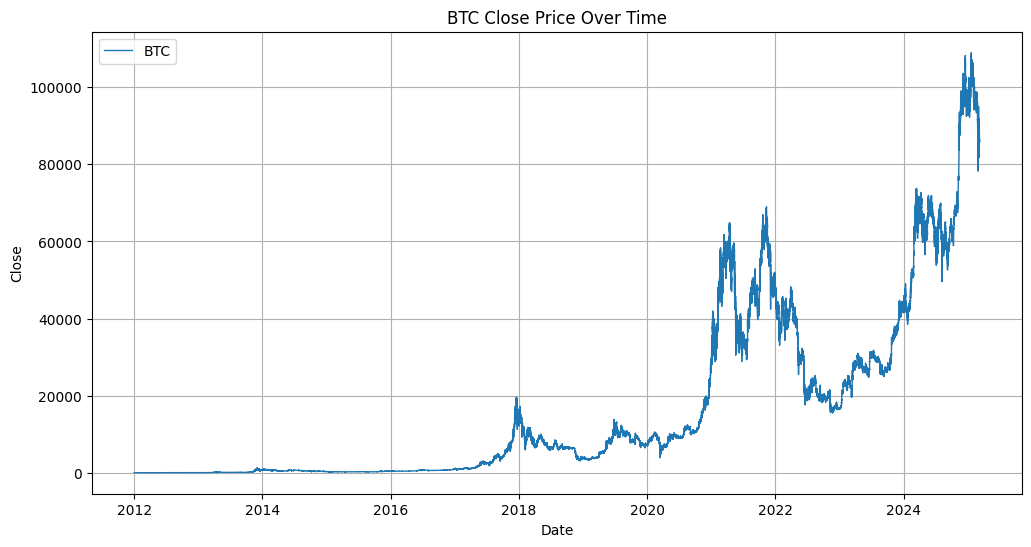

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_crypto_data(df, coin_name="Crypto", date_col="Date", price_col="Close"):
    """
    Plots the crypto price data over time.
    
    Parameters:
        df (pd.DataFrame): DataFrame with a date column and a price column.
        coin_name (str): The name of the crypto (used for the plot title and label).
        date_col (str): The column name in df that contains date information.
        price_col (str): The column name in df that contains the price data.
    """
    # Convert the date column to datetime, coerce errors, and drop invalid dates
    df["Date_dt"] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=["Date_dt"])
    
    plt.figure(figsize=(12, 6))
    plt.plot(df["Date_dt"], df[price_col], label=coin_name, linewidth=1)
    plt.xlabel("Date")
    plt.ylabel(price_col)
    plt.title(f"{coin_name} {price_col} Price Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with BTC data:
plot_crypto_data(btc_df, coin_name="BTC")


In [62]:
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
btc_df.to_csv(btc_processed_file, index=False, compression="gzip")

In [76]:
eth_file = os.path.join(FULL_DATA_DIR, "ETH_1min.csv")
eth_df = pd.read_csv(eth_file)
eth_df = eth_df[["Date", "Open", "High", "Low", "Close", "Volume"]]
eth_df.head()

,Date,Open,High,Low,Close,Volume
0,2020-04-16 00:00:00,152.94,152.94,151.33,151.33,112.724931
1,2020-04-15 23:59:00,152.94,152.94,152.94,152.94,0.000000
2,2020-04-15 23:58:00,153.17,153.17,152.94,152.94,0.013011
3,2020-04-15 23:57:00,152.96,153.20,152.96,153.17,466.782278
4,2020-04-15 23:56:00,153.14,153.14,152.96,152.96,167.930714


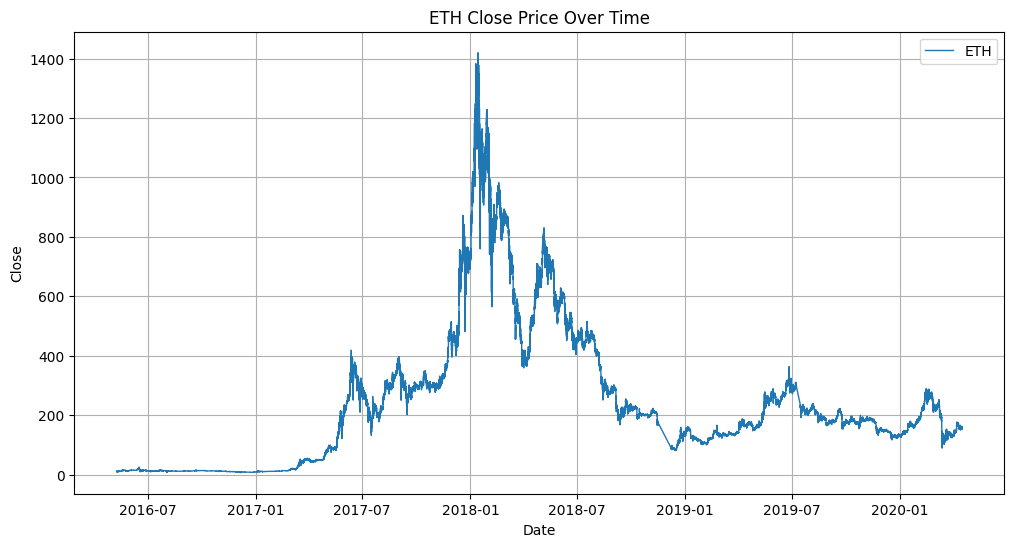

In [77]:
plot_crypto_data(eth_df, coin_name="ETH")

In [78]:
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
eth_df.to_csv(eth_processed_file, index=False, compression="gzip")

In [ ]:
crypto_df = pd.concat([btc_df, eth_df], ignore_index=True)

In [85]:
# Convert the "Date" column to datetime objects (with UTC)
crypto_df["Date"] = pd.to_datetime(crypto_df["Date"], errors="coerce", utc=True)

# Now compute the min and max dates
start_date = crypto_df["Date"].min()
end_date = crypto_df["Date"].max()
print(f"Combined crypto data range: {start_date} to {end_date}")


Combined crypto data range: 2012-01-01 10:01:00+00:00 to 2025-03-09 00:00:00+00:00


In [86]:
# Save the combined DataFrame as a compressed CSV
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
crypto_df.to_csv(combined_file, index=False, compression="gzip")

In [87]:
# Convert the 'Date' column in df_agg to datetime objects with UTC timezone
df_agg["Date_dt"] = pd.to_datetime(df_agg["Date"], errors="coerce", utc=True)

# Filter the DataFrame to include only rows between start_date and end_date
df_filtered_news = df_agg[(df_agg["Date_dt"] >= start_date) & (df_agg["Date_dt"] <= end_date)]

print(f"Filtered news count: {len(df_filtered_news)}")

Filtered news count: 7210953


In [88]:
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")
df_filtered_news.to_csv(NEWS_FILTERED_CSV, compression="gzip", index=False)

## `breakpoint`


You can run this to import all of the files in. Make sure to download the data from hugging face.

In [89]:
import os
import pandas as pd

# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for the processed data files
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")


In [1]:
import os
import pandas as pd

# Define the directory containing processed data files
PROCESSED_DATA = os.path.join("data", "processed-data")

# File paths for the processed data files
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")


/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/1714906350.py:16: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  crypto_df = pd.read_csv(combined_file, compression="gzip")


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar



# Exploratory Data Analysis on the News Dataset


In [2]:
# Check the shape
print("Number of rows and columns in news dataset:", df_filtered_news.shape)

# Peek at the first few rows
df_filtered_news.head(5)

# Check data types
df_filtered_news.info()


Number of rows and columns in news dataset: (7210953, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7210953 entries, 0 to 7210952
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   Date           object
 1   Article_title  object
 2   Stock_symbols  object
 3   Date_dt        object
dtypes: object(4)
memory usage: 220.1+ MB


## Date Range & Missing Values



In [4]:
# Date range
min_date = df_filtered_news["Date_dt"].min()
max_date = df_filtered_news["Date_dt"].max()
print("Earliest date in news:", min_date)
print("Latest date in news:",  max_date)

# Check missing values
missing_counts = df_filtered_news.isnull().sum()
print("Missing values:\n", missing_counts)


Earliest date in news: 2012-01-01 10:04:00+00:00
Latest date in news: 2024-01-09 00:00:00+00:00
Missing values:
 Date                   0
Article_title          0
Stock_symbols    4554201
Date_dt                0
dtype: int64


In [5]:
duplicates_count = df_filtered_news.duplicated().sum()
print("Number of fully duplicated rows:", duplicates_count)


Number of fully duplicated rows: 0


## Articles per Day/Month

Daily articles sample:
    date_only  Article_title
0  2012-01-01            146
1  2012-01-02            750
2  2012-01-03           4558
3  2012-01-04           4593
4  2012-01-05           4985


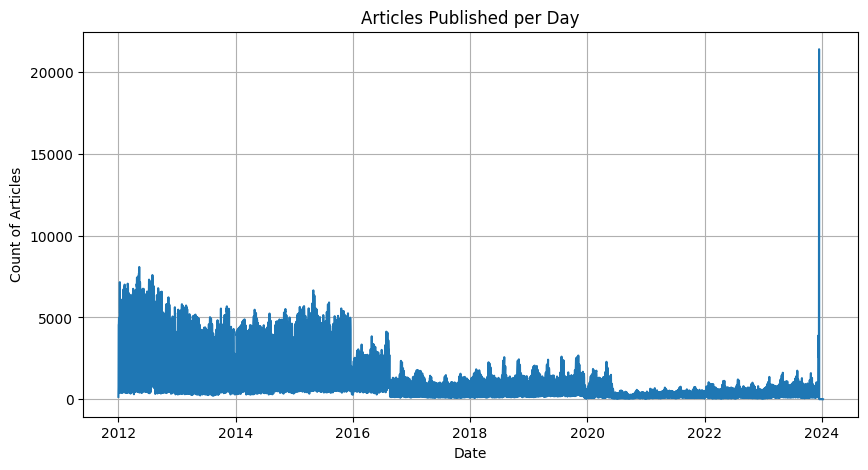

In [9]:
# Convert Date_dt to a daily period
# Make sure Date_dt is parsed as a datetime
df_filtered_news["Date_dt"] = pd.to_datetime(df_filtered_news["Date_dt"], errors="coerce")

# Now you can safely use the .dt accessor
df_filtered_news["date_only"] = df_filtered_news["Date_dt"].dt.date
articles_per_day = df_filtered_news.groupby("date_only")["Article_title"].count().reset_index()

print("Daily articles sample:")
print(articles_per_day.head())

# Plot daily article counts (can be large, so consider a rolling average)
plt.figure(figsize=(10, 5))
plt.plot(articles_per_day["date_only"], articles_per_day["Article_title"])
plt.title("Articles Published per Day")
plt.xlabel("Date")
plt.ylabel("Count of Articles")
plt.grid(True)
plt.show()


## Which day of the week has the highest number of articles

Article counts by weekday:
      weekday  count_of_articles
1     Monday            1065292
5    Tuesday            1449230
6  Wednesday            1485717
4   Thursday            1506549
0     Friday            1194152
2   Saturday             337346
3     Sunday             172667

Weekday with the MOST articles: Thursday (1506549 articles)


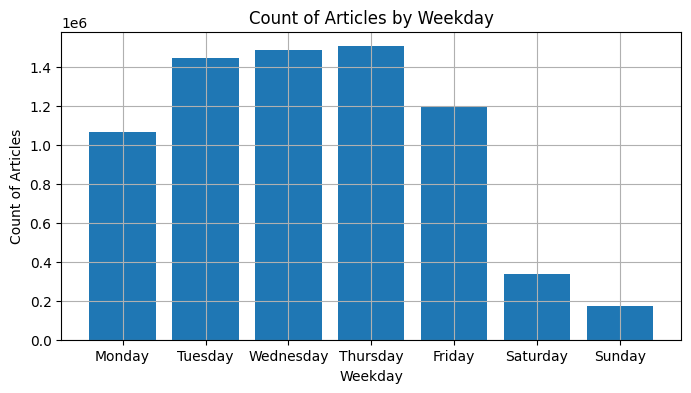

In [28]:
df_filtered_news["Date_dt"] = pd.to_datetime(df_filtered_news["Date_dt"], errors="coerce")

df_filtered_news["weekday"] = df_filtered_news["Date_dt"].dt.day_name()

articles_by_weekday = (
    df_filtered_news
    .groupby("weekday")["Article_title"]
    .count()
    .reset_index(name="count_of_articles")
)

weekday_order = list(calendar.day_name)
articles_by_weekday["weekday"] = pd.Categorical(
    articles_by_weekday["weekday"], 
    categories=weekday_order, 
    ordered=True
)
articles_by_weekday = articles_by_weekday.sort_values("weekday")

print("Article counts by weekday:\n", articles_by_weekday)

max_row = articles_by_weekday.loc[articles_by_weekday["count_of_articles"].idxmax()]
print(f"\nWeekday with the MOST articles: {max_row['weekday']} ({max_row['count_of_articles']} articles)")

plt.figure(figsize=(8, 4))
plt.bar(articles_by_weekday["weekday"], articles_by_weekday["count_of_articles"])
plt.title("Count of Articles by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Count of Articles")
plt.grid(True)
plt.show()

## Top N Stock Symbols

Top 20 stock symbols: [('GILD', 11663), ('BABA', 11489), ('NVDA', 11484), ('WFC', 11137), ('INTC', 10854), ('QQQ', 10428), ('BROGW', 10367), ('TSLA', 10294), ('MRK', 9990), ('BPYPO', 9889), ('GOOG', 9867), ('KO', 9670), ('BHFAL', 9521), ('DIS', 9518), ('T', 9309), ('MU', 9300), ('AAPL', 9141), ('AMD', 9126), ('PMAY', 8991), ('CLSN', 8964)]


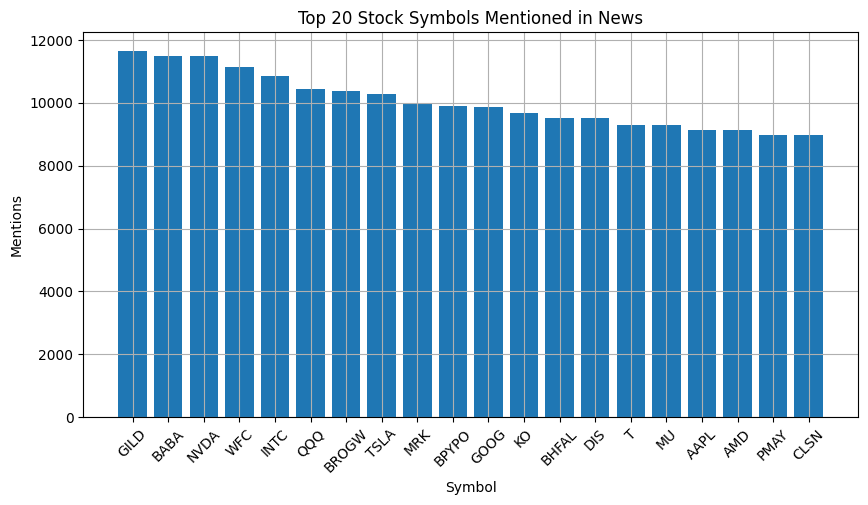

In [10]:
from collections import Counter

symbol_counter = Counter()

for row in df_filtered_news["Stock_symbols"].dropna():
    symbols = [s.strip() for s in row.split(",") if s.strip() != ""]
    symbol_counter.update(symbols)

# Show the top 20
top_symbols = symbol_counter.most_common(20)
print("Top 20 stock symbols:", top_symbols)

# Convert to DataFrame for plotting
symbols_df = pd.DataFrame(top_symbols, columns=["Symbol", "Count"])

plt.figure(figsize=(10, 5))
plt.bar(symbols_df["Symbol"], symbols_df["Count"])
plt.title("Top 20 Stock Symbols Mentioned in News")
plt.xlabel("Symbol")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Text Length & Basic NLP Checks

count    7.210953e+06
mean     6.719732e+01
std      2.714175e+01
min      1.000000e+00
25%      5.100000e+01
50%      6.200000e+01
75%      7.700000e+01
max      5.120000e+02
Name: title_length, dtype: float64


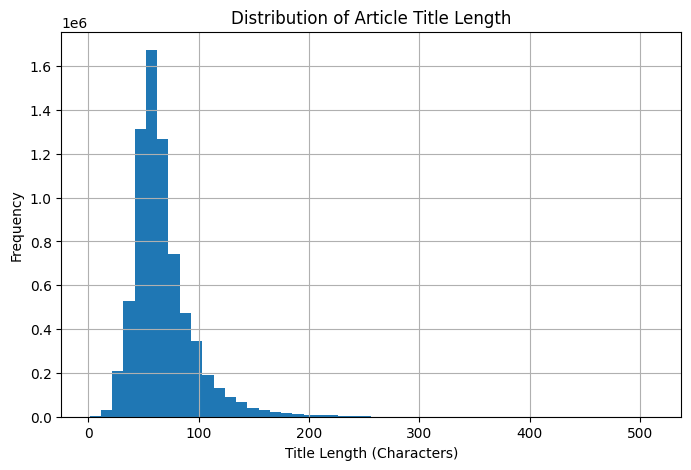

In [11]:
df_filtered_news["title_length"] = df_filtered_news["Article_title"].astype(str).apply(len)

# Basic stats on title length
print(df_filtered_news["title_length"].describe())

plt.figure(figsize=(8, 5))
plt.hist(df_filtered_news["title_length"], bins=50)
plt.title("Distribution of Article Title Length")
plt.xlabel("Title Length (Characters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Exploratory Data Analysis on Crypto Data

In [12]:
print("BTC data shape:", btc_df.shape)
print("ETH data shape:", eth_df.shape)
print("Combined crypto data shape:", crypto_df.shape)

btc_df.info()
eth_df.info()

# Quick look at the combined DataFrame
crypto_df.head(5)


BTC data shape: (6779281, 6)
ETH data shape: (1984012, 7)
Combined crypto data shape: (8763293, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6779281 entries, 0 to 6779280
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
dtypes: float64(5), object(1)
memory usage: 310.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984012 entries, 0 to 1984011
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Date     object 
 1   Open     float64
 2   High     float64
 3   Low      float64
 4   Close    float64
 5   Volume   float64
 6   Date_dt  object 
dtypes: float64(5), object(2)
memory usage: 106.0+ MB


,Date,Open,High,Low,Close,Volume,Date_dt
0,2012-01-01 10:01:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,2012-01-01 10:02:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,2012-01-01 10:03:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,2012-01-01 10:04:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,2012-01-01 10:05:00+00:00,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [13]:
print("BTC Summary:")
print(btc_df.describe())

print("\nETH Summary:")
print(eth_df.describe())


BTC Summary:
               Open          High           Low         Close        Volume
count  6.779281e+06  6.779281e+06  6.779281e+06  6.779281e+06  6.779281e+06
mean   1.507124e+04  1.507766e+04  1.506460e+04  1.507125e+04  5.439022e+00
std    2.068588e+04  2.069364e+04  2.067793e+04  2.068591e+04  2.287430e+01
min    3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00  0.000000e+00
25%    4.150200e+02  4.151500e+02  4.149700e+02  4.150100e+02  1.846336e-02
50%    6.325550e+03  6.327640e+03  6.323090e+03  6.325570e+03  4.972129e-01
75%    2.370003e+04  2.371100e+04  2.369000e+04  2.370022e+04  3.157064e+00
max    1.089460e+05  1.090300e+05  1.087760e+05  1.089600e+05  5.853852e+03

ETH Summary:
               Open          High           Low         Close        Volume
count  1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06  1.984012e+06
mean   2.418247e+02  2.419602e+02  2.416817e+02  2.418249e+02  2.612284e+01
std    2.415172e+02  2.417080e+02  2.413119e+02  2.415171e+02

## Date Range & Missing Values

In [14]:
# BTC date range
btc_df["Date"] = pd.to_datetime(btc_df["Date"], utc=True, errors="coerce")
print("BTC earliest date:", btc_df["Date"].min())
print("BTC latest date:",  btc_df["Date"].max())

# ETH date range
eth_df["Date"] = pd.to_datetime(eth_df["Date"], utc=True, errors="coerce")
print("ETH earliest date:", eth_df["Date"].min())
print("ETH latest date:",  eth_df["Date"].max())

# Check for missing
print("BTC missing values:\n", btc_df.isnull().sum())
print("ETH missing values:\n", eth_df.isnull().sum())


BTC earliest date: 2012-01-01 10:01:00+00:00
BTC latest date: 2025-03-09 00:00:00+00:00
ETH earliest date: 2016-05-09 13:32:00+00:00
ETH latest date: 2020-04-16 00:00:00+00:00
BTC missing values:
 Date      1
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
ETH missing values:
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
Date_dt    0
dtype: int64


## Price Over Time

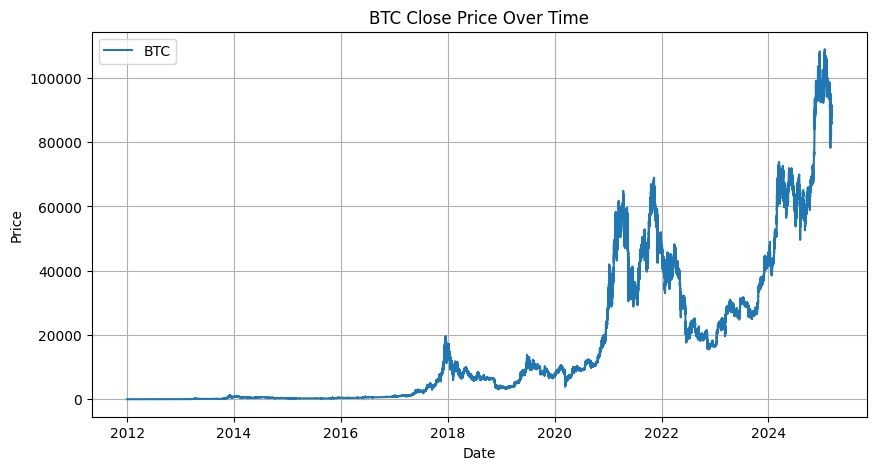

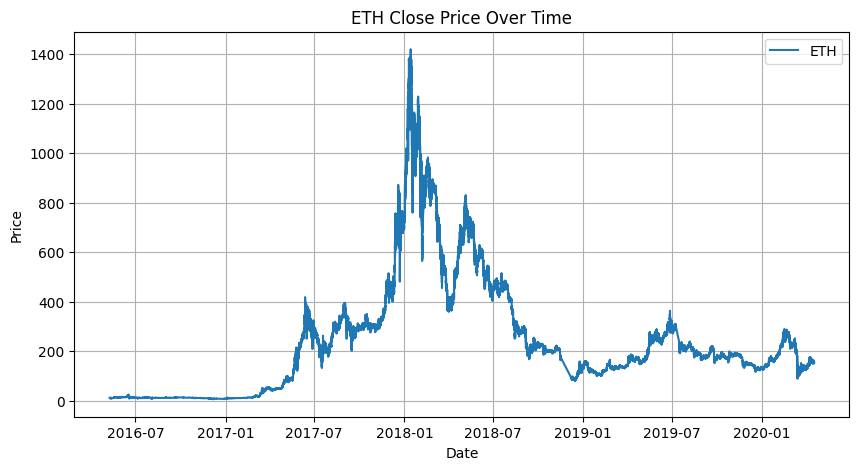

In [15]:
def plot_crypto_data(df, coin_name="Crypto", date_col="Date", price_col="Close"):
    # Convert date col to datetime just in case
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=[date_col, price_col])
    
    plt.figure(figsize=(10, 5))
    plt.plot(df[date_col], df[price_col], label=coin_name)
    plt.title(f"{coin_name} {price_col} Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_crypto_data(btc_df, coin_name="BTC", price_col="Close")
plot_crypto_data(eth_df, coin_name="ETH", price_col="Close")


## Volume Over Time

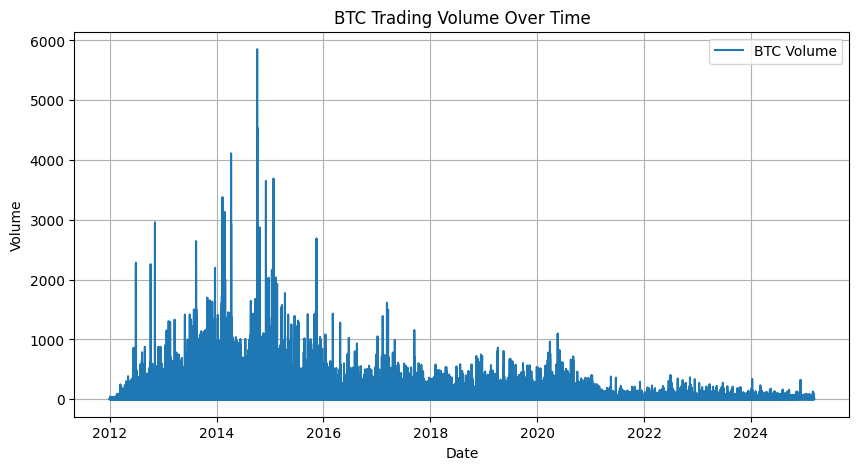

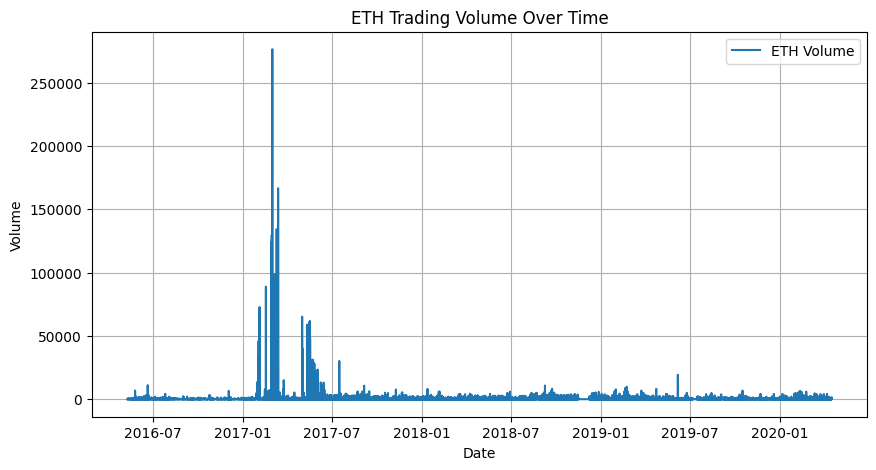

In [16]:
def plot_volume_over_time(df, coin_name="Crypto", date_col="Date", vol_col="Volume"):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", utc=True)
    df = df.dropna(subset=[date_col, vol_col])
    
    plt.figure(figsize=(10, 5))
    plt.plot(df[date_col], df[vol_col], label=f"{coin_name} Volume")
    plt.title(f"{coin_name} Trading Volume Over Time")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_volume_over_time(btc_df, coin_name="BTC")
plot_volume_over_time(eth_df, coin_name="ETH")


## Daily Returns & Volatility

count    4816.000000
mean        0.002924
std         0.041635
min        -0.538385
25%        -0.012227
50%         0.001360
75%         0.018142
max         0.358107
Name: daily_return, dtype: float64
count    1438.000000
mean        0.003873
std         0.061343
min        -0.468599
25%        -0.022472
50%         0.000000
75%         0.025689
max         0.302857
Name: daily_return, dtype: float64


/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/2482960268.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  eth_daily["daily_return"] = eth_daily["Close"].pct_change()


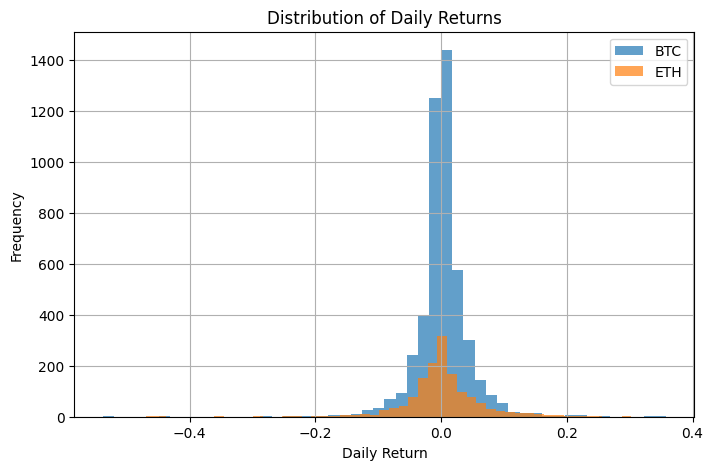

In [17]:
# Resample to daily close for BTC
btc_df["Date"] = pd.to_datetime(btc_df["Date"], utc=True, errors="coerce")
btc_daily = btc_df.set_index("Date").resample("D").agg({"Open": "first", 
                                                        "High": "max", 
                                                        "Low": "min", 
                                                        "Close": "last", 
                                                        "Volume": "sum"})
btc_daily["daily_return"] = btc_daily["Close"].pct_change()

# Resample to daily close for ETH
eth_df["Date"] = pd.to_datetime(eth_df["Date"], utc=True, errors="coerce")
eth_daily = eth_df.set_index("Date").resample("D").agg({"Open": "first", 
                                                        "High": "max", 
                                                        "Low": "min", 
                                                        "Close": "last", 
                                                        "Volume": "sum"})
eth_daily["daily_return"] = eth_daily["Close"].pct_change()

# Check stats on daily returns
print(btc_daily["daily_return"].describe())
print(eth_daily["daily_return"].describe())

# Plot histogram of daily returns
plt.figure(figsize=(8, 5))
plt.hist(btc_daily["daily_return"].dropna(), bins=50, alpha=0.7, label="BTC")
plt.hist(eth_daily["daily_return"].dropna(), bins=50, alpha=0.7, label="ETH")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


/var/folders/69/x0d9sf3x4tn331kv5900b1h80000gn/T/ipykernel_68720/2497639128.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


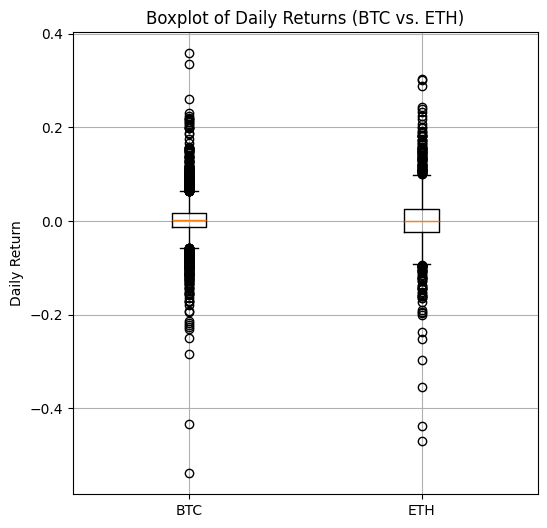

In [20]:
import matplotlib.pyplot as plt

# Boxplots side-by-side
plt.figure(figsize=(6, 6))
plt.boxplot(
    [
        btc_daily["daily_return"].dropna(), 
        eth_daily["daily_return"].dropna()
    ],
    labels=["BTC", "ETH"]
)
plt.title("Boxplot of Daily Returns (BTC vs. ETH)")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()


## Time Series of Daily Returns
Seeing the raw daily returns over time can hint at periods of high or low volatility

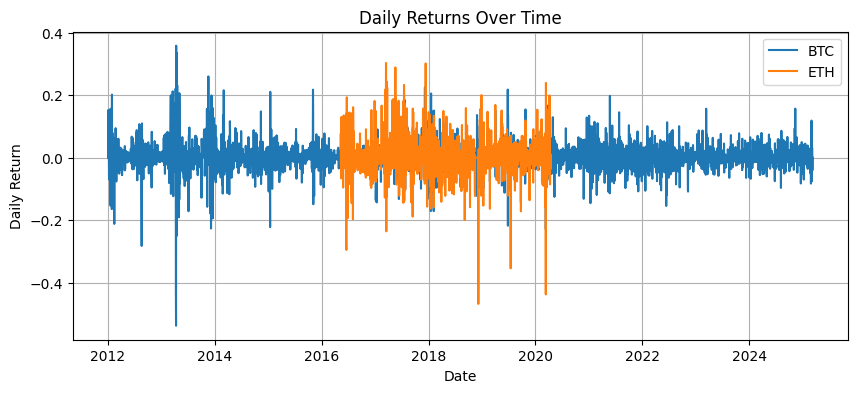

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(btc_daily.index, btc_daily["daily_return"], label="BTC")
plt.plot(eth_daily.index, eth_daily["daily_return"], label="ETH")
plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()


## Weekday Analysis

In [22]:
btc_daily_reset = btc_daily.reset_index()
btc_daily_reset["weekday"] = btc_daily_reset["Date"].dt.day_name()  


eth_daily_reset = eth_daily.reset_index()
eth_daily_reset["weekday"] = eth_daily_reset["Date"].dt.day_name()




In [23]:
btc_weekday_stats = btc_daily_reset.groupby("weekday")["daily_return"].agg(
    mean_return=("mean"),
    median_return=("median"),
    count=("size"),
    max_return=("max"),
    min_return=("min"),
    std_dev=("std")
).reset_index()

eth_weekday_stats = eth_daily_reset.groupby("weekday")["daily_return"].agg(
    mean_return=("mean"),
    median_return=("median"),
    count=("size"),
    max_return=("max"),
    min_return=("min"),
    std_dev=("std")
).reset_index()

print("BTC weekday stats:\n", btc_weekday_stats)
print("\nETH weekday stats:\n", eth_weekday_stats)


BTC weekday stats:
      weekday  mean_return  median_return  count  max_return  min_return  \
0     Friday     0.001504       0.001159    688    0.358107   -0.226969   
1     Monday     0.006252       0.002947    688    0.259831   -0.171537   
2   Saturday     0.002117       0.001089    688    0.206092   -0.164966   
3     Sunday     0.000094       0.000383    689    0.201629   -0.282845   
4   Thursday     0.001485       0.000210    688    0.225064   -0.538385   
5    Tuesday     0.004860       0.002325    688    0.217376   -0.250575   
6  Wednesday     0.004159       0.002336    688    0.334816   -0.433551   

    std_dev  
0  0.041623  
1  0.042771  
2  0.032313  
3  0.034428  
4  0.048912  
5  0.041014  
6  0.047483  

ETH weekday stats:
      weekday  mean_return  median_return  count  max_return  min_return  \
0     Friday     0.005412       0.002145    205    0.288481   -0.468599   
1     Monday     0.006085       0.000000    206    0.232527   -0.159326   
2   Saturday     0.00

In [ ]:
import calendar

weekday_order = list(calendar.day_name)  # ["Monday", "Tuesday", ..., "Sunday"]

btc_weekday_stats["weekday"] = pd.Categorical(
    btc_weekday_stats["weekday"],
    categories=weekday_order,
    ordered=True
)
btc_weekday_stats = btc_weekday_stats.sort_values("weekday")


In [25]:
print("BTC highest average daily return on:\n",
      btc_weekday_stats.loc[btc_weekday_stats["mean_return"].idxmax()])

print("\nETH highest average daily return on:\n",
      eth_weekday_stats.loc[eth_weekday_stats["mean_return"].idxmax()])


BTC highest average daily return on:
 weekday            Monday
mean_return      0.006252
median_return    0.002947
count                 688
max_return       0.259831
min_return      -0.171537
std_dev          0.042771
Name: 1, dtype: object

ETH highest average daily return on:
 weekday           Tuesday
mean_return      0.006649
median_return   -0.000303
count                 206
max_return       0.301401
min_return      -0.354649
std_dev          0.069647
Name: 5, dtype: object


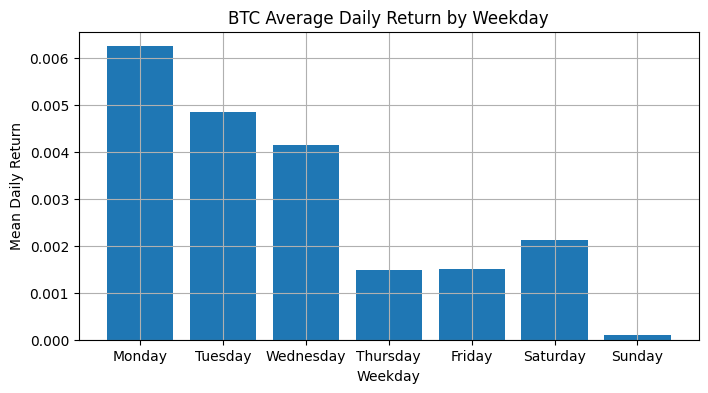

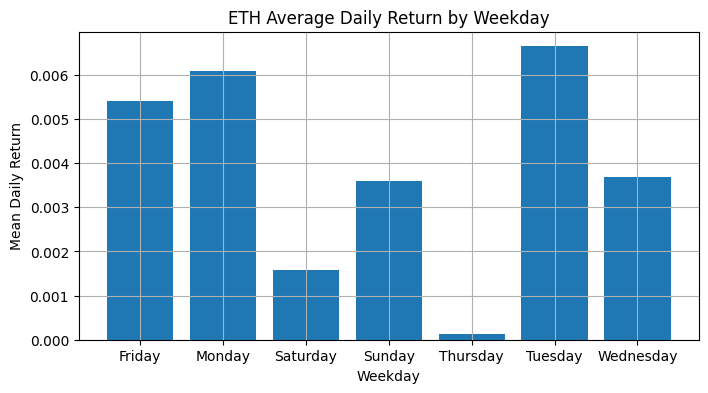

In [26]:
# BTC
plt.figure(figsize=(8, 4))
plt.bar(btc_weekday_stats["weekday"], btc_weekday_stats["mean_return"])
plt.title("BTC Average Daily Return by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Mean Daily Return")
plt.grid(True)
plt.show()

# ETH
plt.figure(figsize=(8, 4))
plt.bar(eth_weekday_stats["weekday"], eth_weekday_stats["mean_return"])
plt.title("ETH Average Daily Return by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Mean Daily Return")
plt.grid(True)
plt.show()


## Correlation Between BTC & ETH

In [18]:
# Join daily returns for BTC and ETH on the date index
merged_daily = pd.DataFrame({
    "BTC_return": btc_daily["daily_return"],
    "ETH_return": eth_daily["daily_return"]
}).dropna()

correlation = merged_daily.corr()
print("Correlation between BTC and ETH daily returns:\n", correlation)


Correlation between BTC and ETH daily returns:
             BTC_return  ETH_return
BTC_return     1.00000     0.46913
ETH_return     0.46913     1.00000


The daily returns of BTC and ETH have a moderate correlation of approximately 0.47, meaning they often move in the same direction but not in perfect unison.


In [ ]:
import pandas as pd

btc_df["Date"] = pd.to_datetime(btc_df["Date"], errors="coerce", utc=True)
eth_df["Date"] = pd.to_datetime(eth_df["Date"], errors="coerce", utc=True)

btc_df = btc_df.sort_values("Date").set_index("Date")
eth_df = eth_df.sort_values("Date").set_index("Date")

btc_df["minute_return"] = btc_df["Close"].pct_change()
eth_df["minute_return"] = eth_df["Close"].pct_change()

merged_minute = pd.merge(
    btc_df[["minute_return"]],
    eth_df[["minute_return"]],
    left_index=True,
    right_index=True,
    suffixes=("_BTC", "_ETH")
).dropna()

correlation_minute = merged_minute.corr()
print("Correlation between BTC and ETH minute-level returns:\n", correlation_minute)


Correlation between BTC and ETH minute-level returns:
                    minute_return_BTC  minute_return_ETH
minute_return_BTC           1.000000           0.000242
minute_return_ETH           0.000242           1.000000


The corrolation drops alot when doing a minute return.

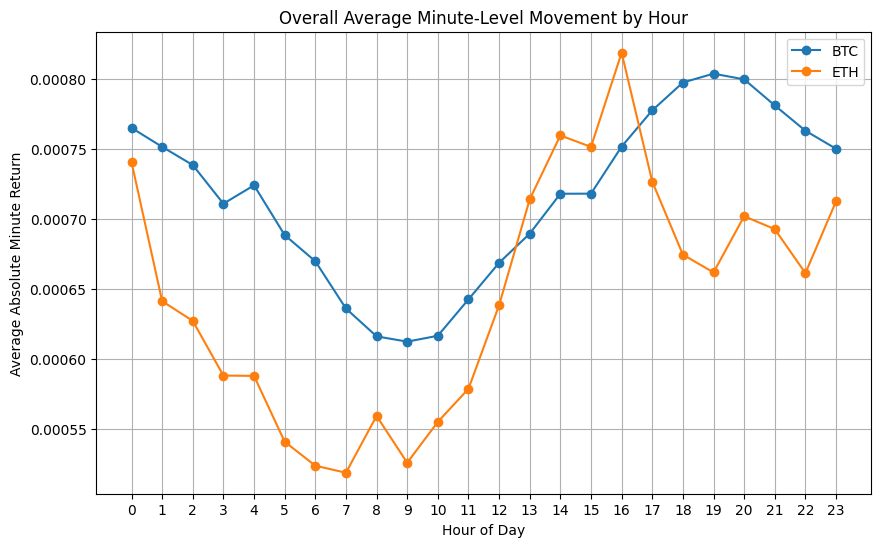

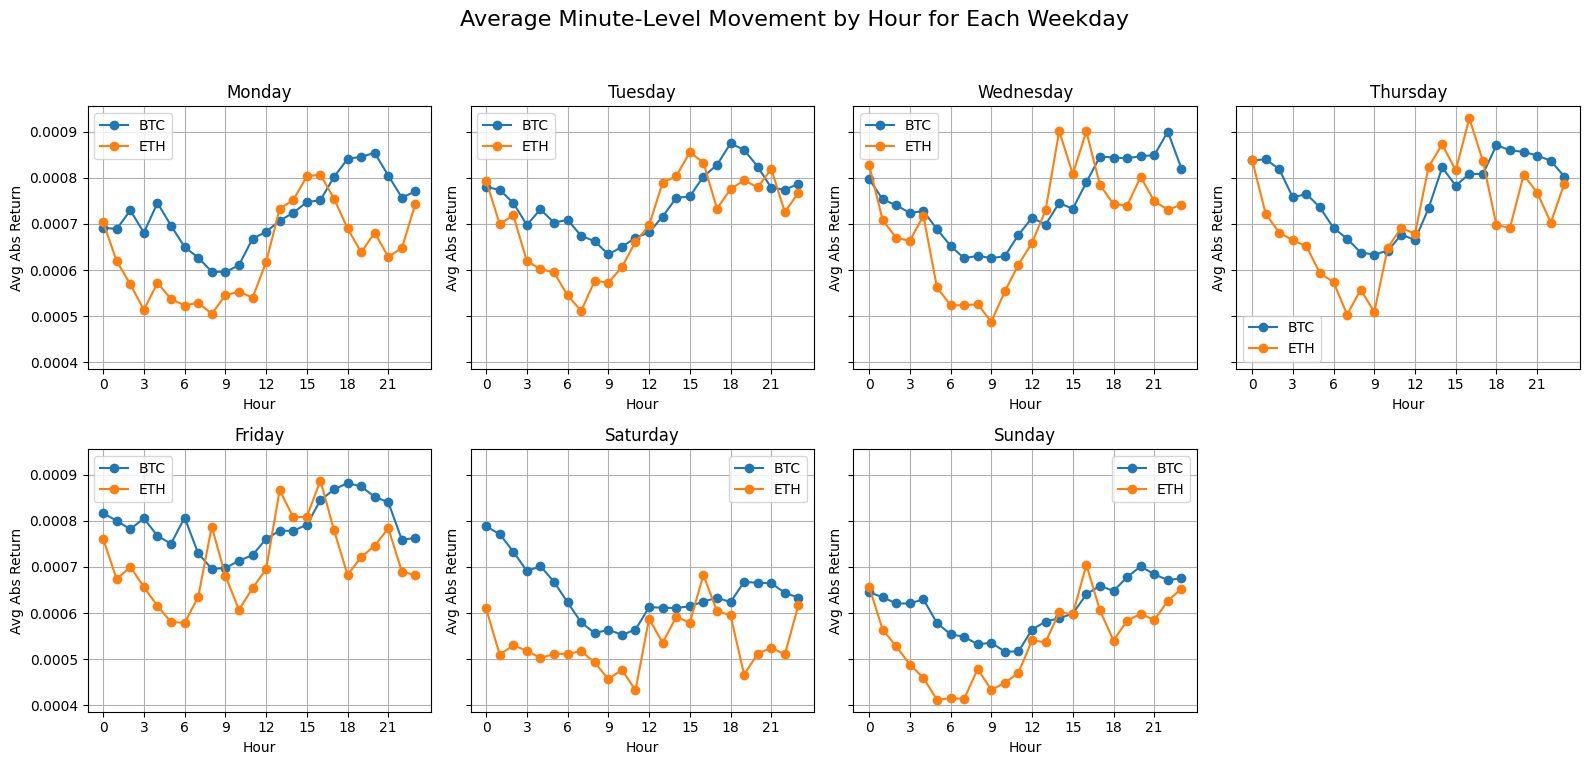

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

def prepare_df(df):
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce", utc=True)
        df = df.sort_values("Date").set_index("Date")
    else:
        df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
        df = df.sort_index()
    return df

def calculate_minute_returns(df):
    df["minute_return"] = df["Close"].pct_change()
    df["abs_minute_return"] = df["minute_return"].abs()
    return df

def analyze_overall_hourly_movement(btc_df, eth_df):
    btc_df = prepare_df(btc_df)
    eth_df = prepare_df(eth_df)
    btc_df = calculate_minute_returns(btc_df)
    eth_df = calculate_minute_returns(eth_df)
    btc_df["hour"] = btc_df.index.hour
    eth_df["hour"] = eth_df.index.hour
    btc_hourly = btc_df.groupby("hour")["abs_minute_return"].mean().reset_index(name="btc_avg_movement")
    eth_hourly = eth_df.groupby("hour")["abs_minute_return"].mean().reset_index(name="eth_avg_movement")
    overall = pd.merge(btc_hourly, eth_hourly, on="hour")
    plt.figure(figsize=(10, 6))
    plt.plot(overall["hour"], overall["btc_avg_movement"], marker="o", label="BTC")
    plt.plot(overall["hour"], overall["eth_avg_movement"], marker="o", label="ETH")
    plt.title("Overall Average Minute-Level Movement by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Absolute Minute Return")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.legend()
    plt.show()
    return overall

def analyze_hourly_movement_by_weekday(btc_df, eth_df):
    btc_df = prepare_df(btc_df)
    eth_df = prepare_df(eth_df)
    btc_df = calculate_minute_returns(btc_df)
    eth_df = calculate_minute_returns(eth_df)
    btc_df["hour"] = btc_df.index.hour
    eth_df["hour"] = eth_df.index.hour
    btc_df["weekday"] = btc_df.index.day_name()
    eth_df["weekday"] = eth_df.index.day_name()
    weekdays = list(calendar.day_name)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)
    axes = axes.flatten()
    for i, day in enumerate(weekdays):
        btc_day = btc_df[btc_df["weekday"] == day]
        eth_day = eth_df[eth_df["weekday"] == day]
        btc_hourly = btc_day.groupby("hour")["abs_minute_return"].mean().reset_index(name="btc_avg_movement")
        eth_hourly = eth_day.groupby("hour")["abs_minute_return"].mean().reset_index(name="eth_avg_movement")
        ax = axes[i]
        ax.plot(btc_hourly["hour"], btc_hourly["btc_avg_movement"], marker="o", label="BTC")
        ax.plot(eth_hourly["hour"], eth_hourly["eth_avg_movement"], marker="o", label="ETH")
        ax.set_title(day)
        ax.set_xlabel("Hour")
        ax.set_ylabel("Avg Abs Return")
        ax.set_xticks(range(0, 24, 3))
        ax.grid(True)
        ax.legend()
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle("Average Minute-Level Movement by Hour for Each Weekday", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

overall = analyze_overall_hourly_movement(btc_df.copy(), eth_df.copy())
analyze_hourly_movement_by_weekday(btc_df.copy(), eth_df.copy())


Both coins show low volatility during the early hours (2–5 UTC), a midday dip (around 7–10 UTC), and higher volatility later in the day (roughly 18–22 UTC). Their overall hour-by-hour patterns track closely, though one may slightly exceed the other at certain times.

By weekday, the same intraday rhythms repeat: lower activity overnight, a trough in mid-morning, and a stronger peak from late afternoon to evening. Monday often has heightened movement (reflecting weekend news), while weekends are generally calmer until Sunday evening. Across all days, BTC and ETH behave similarly, with overlapping peaks and dips tied to global market overlaps.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm


PROCESSED_DATA = os.path.join("data", "processed-data")


In [5]:

# File paths
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file      = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV  = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")


In [ ]:

def prepare_df(df):

    # Convert 'Date' to datetime & drop NaNs
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    
    # Set and sort index
    df.set_index('Date', inplace=True)
    df.sort_index(ascending=True, inplace=True)

    # Create a human-readable minute-based ID column: YYYYMMDDHHMM
    df["minute_id"] = df.index.strftime("%Y%m%d%H%M").astype(int)
    
    return df

def add_time_based_price_changes_merge_asof(df, offsets, price_col='Close'):

    df_reset = df.reset_index().rename(columns={'Date': 'time'})
    df_reset.sort_values('time', inplace=True)
    
    earliest_time = df_reset["time"].min()
    for label, offset_str in offsets:
        offset_td = pd.Timedelta(offset_str)
        target_col = f"target_time_{label}"
        
        df_reset[target_col] = df_reset["time"] - offset_td
        
        temp = df_reset[["time", price_col]].copy()
        merged = pd.merge_asof(
            df_reset,
            temp,
            left_on=target_col,
            right_on="time",
            direction="backward",
            suffixes=("", f"_{label}_ago")
        )
        
        old_price_col = f"{price_col}_{label}_ago"
        df_reset[old_price_col] = merged[old_price_col]
        
        df_reset.loc[df_reset[target_col] < earliest_time, old_price_col] = np.nan
        
        df_reset[f"PctChange_{label}"] = (
            (df_reset[price_col] - df_reset[old_price_col]) / df_reset[old_price_col]
        )
        
        df_reset.drop(columns=[target_col], inplace=True)
    
    df_final = df_reset.set_index("time")
    return df_final


def add_time_based_price_changes_shift(df, offsets, price_col='Close'):
    for label, num_minutes in offsets:
        old_price_col = f"{price_col}_{label}_ago"
        df[old_price_col] = df[price_col].shift(num_minutes)
        df[f"PctChange_{label}"] = (
            (df[price_col] - df[old_price_col]) / df[old_price_col]
        )
    return df

def add_moving_averages(df, windows=[20, 50, 200], price_col='Close'):
    for w in windows:
        df[f'SMA_{w}'] = df[price_col].rolling(window=w).mean()
        df[f'EMA_{w}'] = df[price_col].ewm(span=w, adjust=False).mean()
    return df

def add_rsi(df, period=14, price_col='Close', rsi_col='RSI'):
    delta = df[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    df[rsi_col] = 100 - (100 / (1 + rs))
    return df

def add_macd(df, short=12, long=26, signal=9, price_col='Close'):
    ema_short = df[price_col].ewm(span=short, adjust=False).mean()
    ema_long = df[price_col].ewm(span=long, adjust=False).mean()
    df['MACD'] = ema_short - ema_long
    df['MACD_Signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    return df

def add_bollinger_bands(df, window=20, n_std=2, price_col='Close'):
    rolling_mean = df[price_col].rolling(window=window).mean()
    rolling_std = df[price_col].rolling(window=window).std()
    df['BB_Middle'] = rolling_mean
    df['BB_Upper'] = rolling_mean + (n_std * rolling_std)
    df['BB_Lower'] = rolling_mean - (n_std * rolling_std)
    return df

def add_volume_oscillator(df, short=5, long=20, volume_col='Volume'):
    df['VolMA_short'] = df[volume_col].rolling(window=short).mean()
    df['VolMA_long'] = df[volume_col].rolling(window=long).mean()
    df['VolumeOscillator'] = (
        (df['VolMA_short'] - df['VolMA_long']) / df['VolMA_long']
    ) * 100
    return df

def add_obv(df, price_col='Close', volume_col='Volume'):
    """
    Vectorized On-Balance Volume calculation.
    sign() → +1 if close>prev_close, -1 if close<prev_close, 0 otherwise
    Then cumulative sum.
    """
    price_diff = df[price_col].diff()
    direction = np.sign(price_diff).fillna(0)
    

    df['OBV'] = (direction * df[volume_col]).fillna(0).cumsum()
    return df

def add_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close'):
    df['candle_range'] = df[high_col] - df[low_col]
    df['body_size'] = (df[close_col] - df[open_col]).abs()
    df['Doji'] = (df['body_size'] <= 0.1 * df['candle_range']).astype(int)
    return df

def add_atr(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['prev_close'] = df[close_col].shift(1)
    df['tr1'] = df[high_col] - df[low_col]
    df['tr2'] = (df[high_col] - df['prev_close']).abs()
    df['tr3'] = (df[low_col] - df['prev_close']).abs()
    df['TR'] = df[['tr1','tr2','tr3']].max(axis=1)
    
    # Exponential Weighted Moving Average
    df['ATR'] = df['TR'].ewm(alpha=1/period, adjust=False).mean()
    
    df.drop(columns=['prev_close','tr1','tr2','tr3','TR'], inplace=True)
    return df

def add_adx(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['prev_high'] = df[high_col].shift(1)
    df['prev_low']  = df[low_col].shift(1)
    df['prev_close']= df[close_col].shift(1)
    
    df['tr1'] = df[high_col] - df[low_col]
    df['tr2'] = (df[high_col] - df['prev_close']).abs()
    df['tr3'] = (df[low_col] - df['prev_close']).abs()
    
    df['TR'] = df[['tr1','tr2','tr3']].max(axis=1)
    df['+DM'] = np.where(
        (df[high_col] - df['prev_high']) > (df['prev_low'] - df[low_col]),
        np.clip(df[high_col] - df['prev_high'], a_min=0, a_max=None),
        0
    )
    df['-DM'] = np.where(
        (df['prev_low'] - df[low_col]) > (df[high_col] - df['prev_high']),
        np.clip(df['prev_low'] - df[low_col], a_min=0, a_max=None),
        0
    )
    
    df['TR_ema'] = df['TR'].ewm(alpha=1/period, adjust=False).mean()
    df['+DM_ema'] = df['+DM'].ewm(alpha=1/period, adjust=False).mean()
    df['-DM_ema'] = df['-DM'].ewm(alpha=1/period, adjust=False).mean()
    
    df['+DI'] = 100 * (df['+DM_ema'] / df['TR_ema'])
    df['-DI'] = 100 * (df['-DM_ema'] / df['TR_ema'])
    df['DX'] = 100 * ( (df['+DI'] - df['-DI']).abs() / (df['+DI'] + df['-DI']) )
    df['ADX'] = df['DX'].ewm(alpha=1/period, adjust=False).mean()
    
    df.drop(columns=['prev_high','prev_low','prev_close','tr1','tr2','tr3','TR',
                     '+DM','-DM','TR_ema','+DM_ema','-DM_ema','DX'], inplace=True)
    return df

def add_stochastic(df, k_window=14, d_window=3, high_col='High', low_col='Low', close_col='Close'):
    df['roll_low']  = df[low_col].rolling(k_window).min()
    df['roll_high'] = df[high_col].rolling(k_window).max()
    df['%K'] = 100 * (df[close_col] - df['roll_low']) / (df['roll_high'] - df['roll_low'])
    df['%D'] = df['%K'].rolling(d_window).mean()
    
    df.drop(columns=['roll_low','roll_high'], inplace=True)
    return df

def add_williams_r(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['roll_high'] = df[high_col].rolling(period).max()
    df['roll_low']  = df[low_col].rolling(period).min()
    df['Williams_%R'] = -100 * (df['roll_high'] - df[close_col]) / (df['roll_high'] - df['roll_low'])
    
    df.drop(columns=['roll_high','roll_low'], inplace=True)
    return df

def add_all_features(df, use_asof=True):

    df = df.copy()
    

    offsets_asof = [
        ('1m','1min'), 
        ('5m','5min'), 
        ('1h','1h'), 
        ('1d','1d'), 
        ('1w','7d'), 
        ('1mo','30d')
    ]
    

    offsets_shift = [
        ('1m',1), 
        ('5m',5), 
        ('1h',60), 
        ('1d',1440),
        ('1w',10080),
        ('1mo',43200)
    ]
    
    if use_asof:
        df = add_time_based_price_changes_merge_asof(df, offsets_asof, price_col='Close')
    else:
        df = add_time_based_price_changes_shift(df, offsets_shift, price_col='Close')
    
    df = add_moving_averages(df, windows=[20, 50, 200], price_col='Close')
    df = add_rsi(df, period=14, price_col='Close', rsi_col='RSI_14')
    df = add_macd(df, short=12, long=26, signal=9, price_col='Close')
    df = add_bollinger_bands(df, window=20, n_std=2, price_col='Close')
    df = add_volume_oscillator(df, short=5, long=20, volume_col='Volume')
    df = add_obv(df, price_col='Close', volume_col='Volume')
    df = add_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close')
    df = add_atr(df, period=14, high_col='High', low_col='Low', close_col='Close')
    df = add_adx(df, period=14, high_col='High', low_col='Low', close_col='Close')
    df = add_stochastic(df, k_window=14, d_window=3, high_col='High', low_col='Low', close_col='Close')
    df = add_williams_r(df, period=14, high_col='High', low_col='Low', close_col='Close')
    
    df.dropna(inplace=True)
    
    return df

In [10]:
btc_df_prepared = prepare_df(btc_df)

In [11]:
btc_df_features = add_all_features(btc_df_prepared, use_asof=True)

In [ ]:
def convert_datetime_index_to_id(df, datetime_col):
    df.reset_index(inplace=True)  
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['id'] = df[datetime_col].dt.strftime('%Y%m%d%H%M').astype(int)
    df.drop(datetime_col, axis=1, inplace=True)
    df.set_index('id', inplace=True)
    return df



In [ ]:
btc_df_features = convert_datetime_index_to_id(btc_df_features, 'time')

In [9]:
PROCESSED_DATA = os.path.join("data", "processed-data")
btc_output_file = os.path.join(PROCESSED_DATA, "btc_1min_with_features.parquet")


In [ ]:
btc_df_features.to_parquet(btc_output_file, index=True, compression="snappy")

In [10]:

btc_df_features = pd.read_parquet(btc_output_file)

In [ ]:
eth_df = eth_df.reset_index()
eth_df_prepared = prepare_df(eth_df)
eth_df_features = add_all_features(eth_df_prepared, use_asof=True)
eth_df_features.drop(columns=["Date_dt"], inplace=True, errors="ignore") 

In [38]:
eth_df_features = convert_datetime_index_to_id(eth_df_features, 'time')

In [11]:
eth_output_file = os.path.join(PROCESSED_DATA, "eth_1min_with_features.parquet")


In [12]:
eth_df_features = pd.read_parquet(eth_output_file)

In [ ]:
eth_df_features.to_parquet(eth_output_file, index=True, compression="snappy") 

## News

In [ ]:

news_file = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")
news_df = pd.read_csv(news_file, compression="gzip")

In [5]:
# Remove rows with a timestamp exactly "00:00:00"
news_df['Date_dt'] = pd.to_datetime(news_df['Date_dt'], utc=True)
news_df = news_df[news_df['Date_dt'].dt.strftime('%H:%M:%S') != '00:00:00'].copy()

### sentiment-analysis

In [6]:
# Load FinBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")


Device set to use cuda:0


In [ ]:
titles = news_df['Article_title'].tolist()

batch_size = 64
results = sentiment_pipeline(titles, batch_size=batch_size)

In [ ]:
# Build sentiment DataFrame and integrate sentiment results
sentiment_df = pd.DataFrame(results)
news_df['sentiment_score'] = sentiment_df['score']
label_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
news_df['sentiment_label'] = sentiment_df['label'].map(label_map)
news_df['sentiment_label_text'] = sentiment_df['label'].str.lower()

# Text features
news_df['char_count'] = news_df['Article_title'].str.len()
news_df['word_count'] = news_df['Article_title'].str.split().str.len()

# Time features (numeric only)
news_df['minute_floor'] = news_df['Date_dt'].dt.floor('min')
news_df['hour'] = news_df['Date_dt'].dt.hour
news_df['minute_of_hour'] = news_df['Date_dt'].dt.minute
news_df['weekday'] = news_df['Date_dt'].dt.weekday

# Rolling sentiment per day (window = 3)
news_df = news_df.sort_values('Date_dt')
news_df['rolling_sentiment'] = news_df.groupby(news_df['Date_dt'].dt.date)['sentiment_score']\
                                      .transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Minute-level aggregation
agg_df = news_df.groupby('minute_floor').agg(
    article_count = pd.NamedAgg(column='Article_title', aggfunc='count'),
    sentiment_score_mean = pd.NamedAgg(column='sentiment_score', aggfunc='mean'),
    sentiment_score_median = pd.NamedAgg(column='sentiment_score', aggfunc='median'),
    sentiment_label_sum = pd.NamedAgg(column='sentiment_label', aggfunc='sum'),
    sentiment_label_mode = pd.NamedAgg(column='sentiment_label_text', 
                                        aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    char_count_mean = pd.NamedAgg(column='char_count', aggfunc='mean'),
    char_count_median = pd.NamedAgg(column='char_count', aggfunc='median'),
    word_count_mean = pd.NamedAgg(column='word_count', aggfunc='mean'),
    word_count_median = pd.NamedAgg(column='word_count', aggfunc='median'),
    rolling_sentiment_mean = pd.NamedAgg(column='rolling_sentiment', aggfunc='mean')
).reset_index()

agg_df['hour'] = pd.to_datetime(agg_df['minute_floor']).dt.hour
agg_df['minute_of_hour'] = pd.to_datetime(agg_df['minute_floor']).dt.minute
agg_df['weekday'] = pd.to_datetime(agg_df['minute_floor']).dt.weekday

# Daily aggregation (for extra day-level features)
news_df['date'] = news_df['Date_dt'].dt.date
daily_agg = news_df.groupby('date').agg(
    daily_article_count = pd.NamedAgg(column='Article_title', aggfunc='count'),
    daily_sent_label_sum = pd.NamedAgg(column='sentiment_label', aggfunc='sum'),
    daily_sent_score_mean = pd.NamedAgg(column='sentiment_score', aggfunc='mean')
).reset_index()

agg_df['date'] = pd.to_datetime(agg_df['minute_floor']).dt.date
agg_df = agg_df.merge(daily_agg, on='date', how='left')

# Create unique id, drop unwanted columns, and reorder
agg_df['id'] = pd.to_datetime(agg_df['minute_floor']).dt.strftime('%Y%m%d%H%M')
final_df = agg_df.drop(columns=['minute_floor', 'date'])

final_columns = [
    'id', 'hour', 'minute_of_hour', 'weekday', 'article_count',
    'sentiment_score_mean', 'sentiment_score_median',
    'sentiment_label_sum', 'sentiment_label_mode',
    'char_count_mean', 'char_count_median',
    'word_count_mean', 'word_count_median',
    'rolling_sentiment_mean',
    'daily_article_count', 'daily_sent_label_sum', 'daily_sent_score_mean'
]
final_df = final_df[final_columns]

In [ ]:
sentiment_mode_map = {'neutral': 0, 'negative': 1, 'positive': 2}
final_df['sentiment_label_mode_num'] = final_df['sentiment_label_mode'].map(sentiment_mode_map)

In [ ]:
final_df.fillna(0, inplace=True)

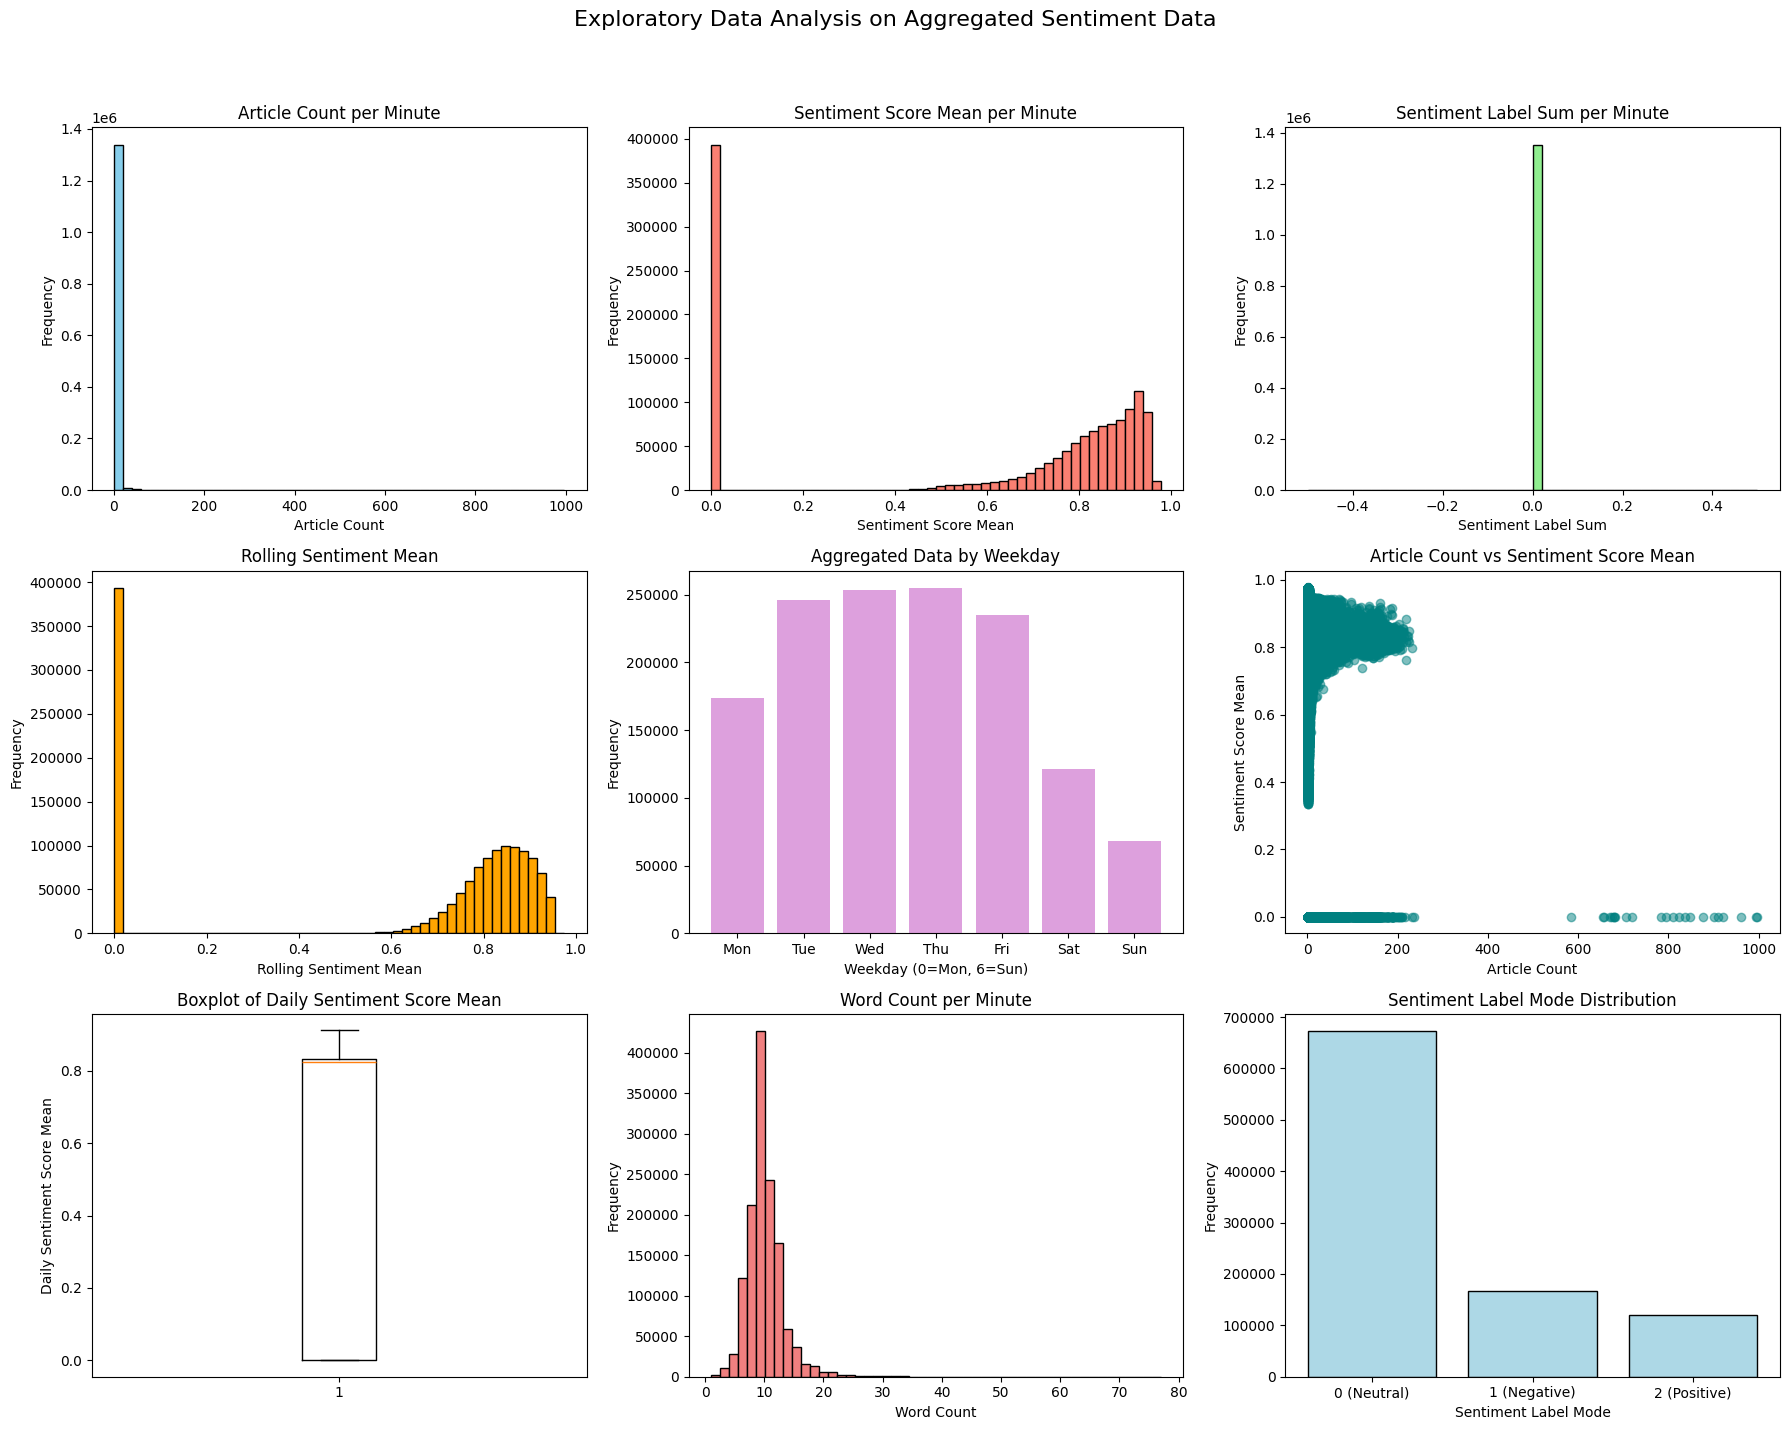

In [ ]:
import matplotlib.pyplot as plt

def plot_final_df_distributions(final_df):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Exploratory Data Analysis on Aggregated Sentiment Data', fontsize=16)

    # Plot 1: Distribution of article_count per minute
    axes[0, 0].hist(final_df['article_count'], bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Article Count per Minute')
    axes[0, 0].set_xlabel('Article Count')
    axes[0, 0].set_ylabel('Frequency')

    # Plot 2: Distribution of sentiment_score_mean per minute
    axes[0, 1].hist(final_df['sentiment_score_mean'], bins=50, color='salmon', edgecolor='black')
    axes[0, 1].set_title('Sentiment Score Mean per Minute')
    axes[0, 1].set_xlabel('Sentiment Score Mean')
    axes[0, 1].set_ylabel('Frequency')

    # Plot 3: Distribution of sentiment_label_sum per minute
    axes[0, 2].hist(final_df['sentiment_label_sum'], bins=50, color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('Sentiment Label Sum per Minute')
    axes[0, 2].set_xlabel('Sentiment Label Sum')
    axes[0, 2].set_ylabel('Frequency')

    # Plot 4: Distribution of rolling_sentiment_mean
    axes[1, 0].hist(final_df['rolling_sentiment_mean'], bins=50, color='orange', edgecolor='black')
    axes[1, 0].set_title('Rolling Sentiment Mean')
    axes[1, 0].set_xlabel('Rolling Sentiment Mean')
    axes[1, 0].set_ylabel('Frequency')

    # Plot 5: Weekday distribution (bar chart)
    weekday_counts = final_df['weekday'].value_counts().sort_index()
    axes[1, 1].bar(weekday_counts.index, weekday_counts.values, color='plum')
    axes[1, 1].set_title('Aggregated Data by Weekday')
    axes[1, 1].set_xlabel('Weekday (0=Mon, 6=Sun)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_xticks(ticks=range(7))
    axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Plot 6: Scatter - Article Count vs Sentiment Score Mean
    axes[1, 2].scatter(final_df['article_count'], final_df['sentiment_score_mean'], alpha=0.5, color='teal')
    axes[1, 2].set_title('Article Count vs Sentiment Score Mean')
    axes[1, 2].set_xlabel('Article Count')
    axes[1, 2].set_ylabel('Sentiment Score Mean')

    # Plot 7: Boxplot of daily_sent_score_mean
    axes[2, 0].boxplot(final_df['daily_sent_score_mean'], vert=True)
    axes[2, 0].set_title('Boxplot of Daily Sentiment Score Mean')
    axes[2, 0].set_ylabel('Daily Sentiment Score Mean')

    # Remove unused axes
    axes[2, 1].hist(final_df['word_count_mean'], bins=50, color='lightcoral', edgecolor='black')
    axes[2, 1].set_title('Word Count per Minute')
    axes[2, 1].set_xlabel('Word Count')
    axes[2, 1].set_ylabel('Frequency')

    # Sentiment Label Mode Distribution (numeric x-axis)
    mode_counts = final_df['sentiment_label_mode_num'].value_counts().sort_index()
    axes[2, 2].bar(mode_counts.index, mode_counts.values, color='lightblue', edgecolor='black')
    axes[2, 2].set_title('Sentiment Label Mode Distribution')
    axes[2, 2].set_xlabel('Sentiment Label Mode')
    axes[2, 2].set_ylabel('Frequency')
    axes[2, 2].set_xticks(list(sentiment_mode_map.values()))
    axes[2, 2].set_xticklabels([f"{v} ({k.capitalize()})" for k, v in sentiment_mode_map.items()])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_final_df_distributions(final_df)

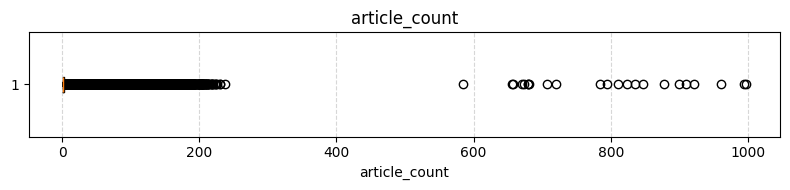

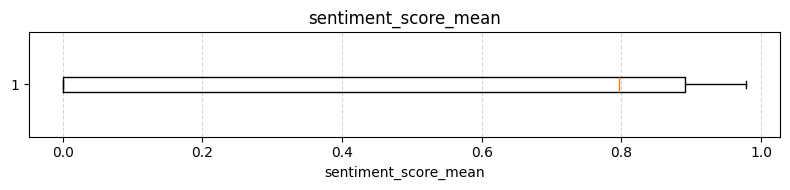

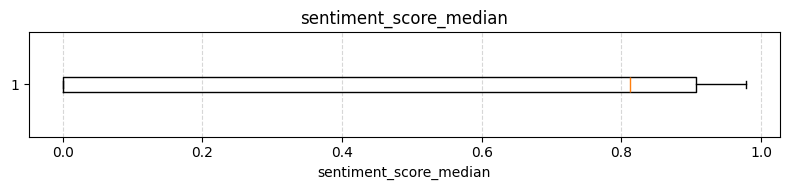

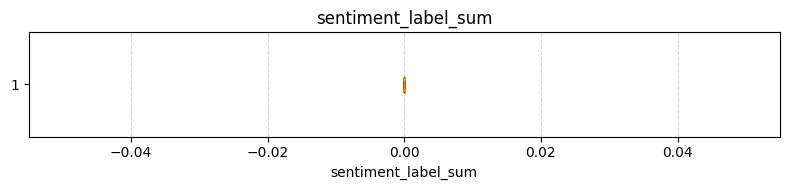

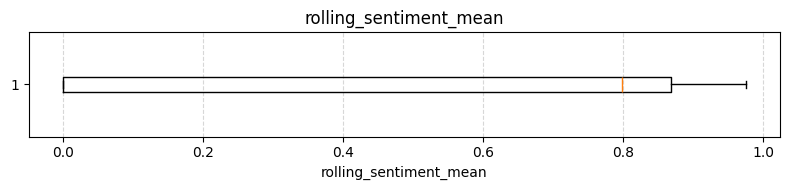

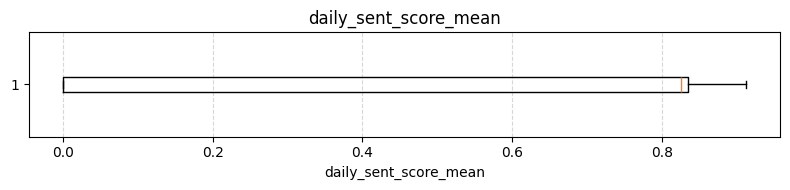

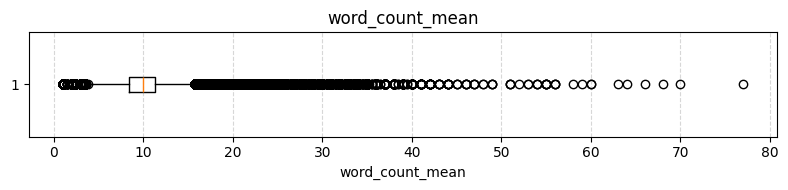

In [83]:
import matplotlib.pyplot as plt

# Function to detect outliers using the IQR method
def detect_outliers(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# List of columns to check for outliers
cols_to_check = [
    'article_count', 
    'sentiment_score_mean', 
    'sentiment_score_median', 
    'sentiment_label_sum', 
    'rolling_sentiment_mean',
    'daily_sent_score_mean',
    'word_count_mean'
]

def plot_boxplots(df, cols, figsize=(8, 2)):
    for col in cols:
        plt.figure(figsize=figsize)
        plt.boxplot(df[col], vert=False)
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

plot_boxplots(final_df, cols_to_check)


We initially were thinking of removing the outliers, but decided to leave them as is. They seem to be natural variations.

In [ ]:
final_df = final_df.set_index('id')

In [ ]:
agg_news_features_df = final_df

In [9]:
agg_news_parquet_path = os.path.join(PROCESSED_DATA, "aggregated_news_with_features.parquet")
agg_news_features_df.to_parquet(agg_news_parquet_path, index=True, compression="snappy")


In [10]:
agg_news_features_df = pd.read_parquet(agg_news_parquet_path)


In [14]:
agg_news_features_df.columns

Index(['id', 'hour', 'minute_of_hour', 'weekday', 'article_count',
       'sentiment_score_mean', 'sentiment_score_median', 'char_count_mean',
       'char_count_median', 'word_count_mean', 'word_count_median',
       'rolling_sentiment_mean', 'daily_article_count',
       'daily_sent_score_mean', 'sentiment_label_mode_num'],
      dtype='object')

In [ ]:
agg_news_features_df.index = pd.to_datetime(
    agg_news_features_df.index, format="%Y%m%d%H%M", errors='coerce'
)

In [16]:
agg_news_features_df['datetime'] = pd.to_datetime(agg_news_features_df['id'], format="%Y%m%d%H%M", errors='coerce')
agg_news_features_df = agg_news_features_df.set_index('datetime')

In [17]:
agg_news_features_df = agg_news_features_df.sort_index()


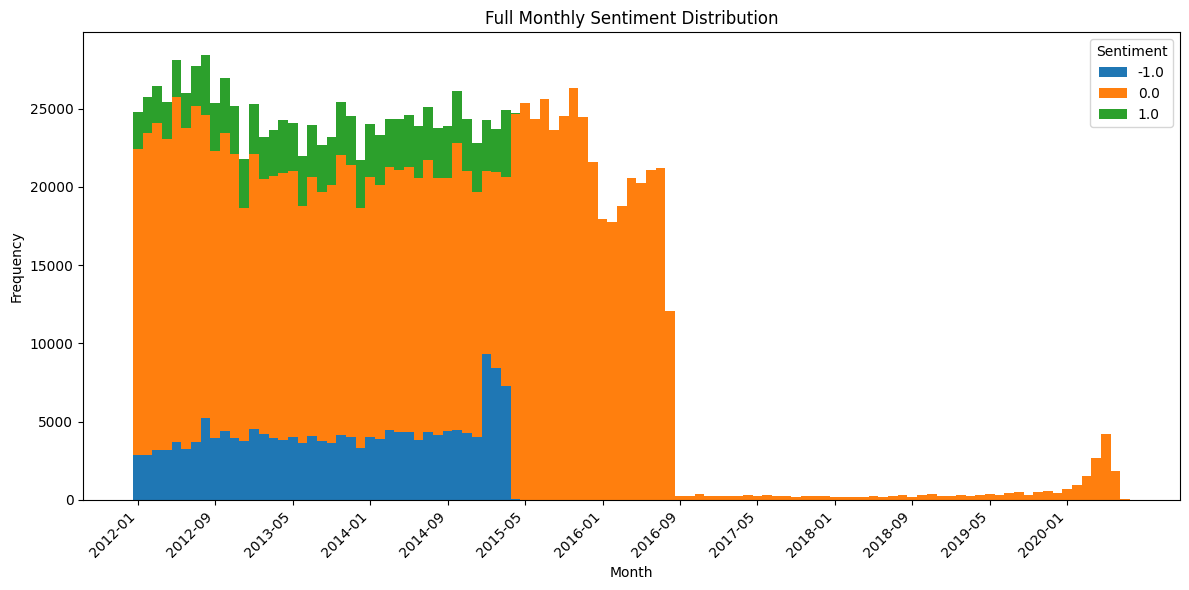

In [ ]:
def plot_monthly_sentiment_distribution(monthly_df, title="Monthly Sentiment Distribution"):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(monthly_df.index))
    bottom = np.zeros(len(x))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

    for i, col in enumerate(monthly_df.columns):
        vals = monthly_df[col].values
        ax.bar(x, vals, bottom=bottom, color=colors[i % len(colors)], width=1.0, label=str(col))
        bottom += vals

    xtick_spacing = max(1, len(x) // 12) 
    xticks = x[::xtick_spacing]
    xtick_labels = [ts.strftime('%Y-%m') for ts in monthly_df.index[::xtick_spacing]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Frequency")
    ax.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

# Plot for the full dataset
plot_monthly_sentiment_distribution(monthly_counts, title="Full Monthly Sentiment Distribution")


Lower bound: 2012-01-31 00:00:00
Upper bound: 2015-03-31 00:00:00


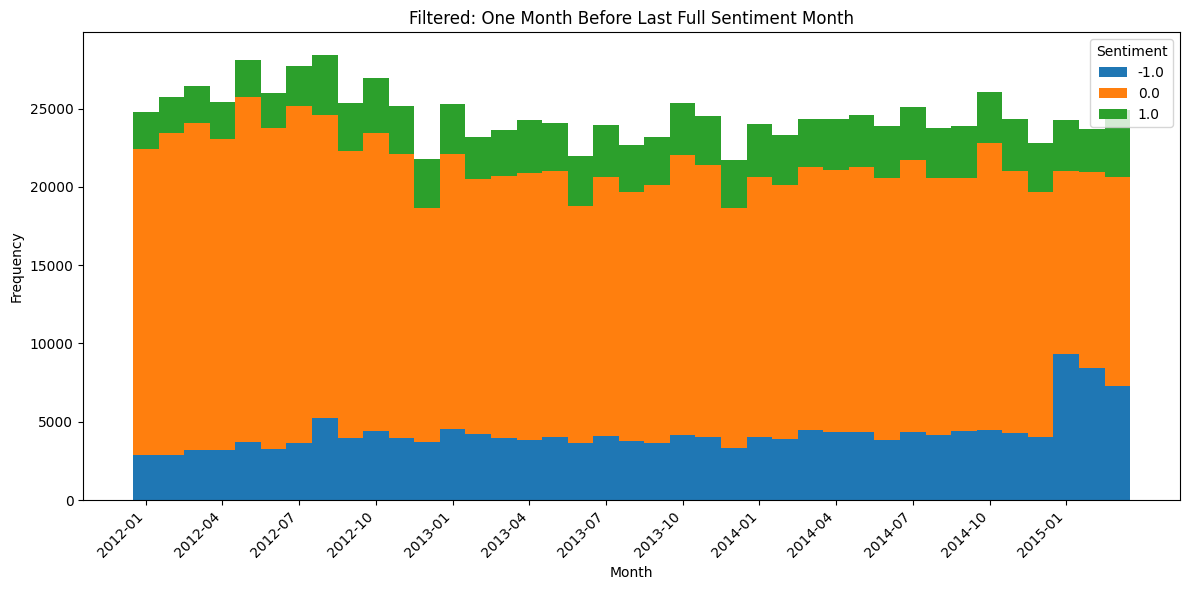

In [30]:
required_labels = [-1.0, 0.0, 1.0]
has_all_three = (monthly_counts[required_labels] > 0).all(axis=1)
last_valid_month = monthly_counts[has_all_three].index[-2]
monthly_counts_filtered = monthly_counts.loc[:last_valid_month]

lower_bound = monthly_counts_filtered.index[0]
upper_bound = monthly_counts_filtered.index[-1]

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

plot_monthly_sentiment_distribution(
    monthly_counts_filtered,
    title="Filtered: One Month Before Last Full Sentiment Month"
)
